# Normalization

At the *alignment* stage, CollateX identifies the tokens to align by comparing them character by character in order to determine whether they are identical or not. At this stage of the process, CollateX cannot recognize when two strings are similar, but not identical, and tokens that are at all different are treated the same way regardless of where they fall on the scale between having no characters in common and having all but one character in common. By default, CollateX assumes that uppercase and lowercase letters should be considered different for alignment purposes, it doesn’t know whether you want differences in punctuation (or the presence vs. absence of punctuation) to be regarded as a textual difference during collation, and in situations where you can represent the same character in more than one way (e.g., “á” might be encoded as either a single a-with-acute-accent character, or as a sequence of two characters: a regular “a” and a floating acute diacritic that is rendered over it), it doesn’t know that a human considers these two representations to be informationally identical. Telling CollateX which systematic differences should be ignored during alignment is the responsibility of the *normalization* stage of the Gothenburg model.

The Gothenburg model separates this *normalization* or *regularization* (stage 2) from the alignment itself (stage 3). The reason for this division lies in the general modular philosophy of the Gothenburg model, which is designed to make it possible for users to modify one operation (such as normalization) without having to intervene in any other (such as alignment). 

By default, CollateX ignores trailing whitespace for alignment purposes, so that, for example, it will treat “koala” (five characters) as identical to “koala ” (six characters, including a trailing space). While we might describe this casually by saying that CollateX ignores trailing whitespace during alignment, a more accurate description is that the special treatment of trailing whitespace is the default *normalization* (Gothenburg stage 2) built into CollateX, that it happens before alignment (stage 3), and alignment then operates on the normalized forms. It may be helpful to think of a normalized form as a *shadow* of a token; CollateX creates the shadow and uses it as the basis for subsequent alignment decisions, but the user typically never sees it, and only the original non-normalized token is output during visualization (stage 5). The Gothenburg model says that we should be able to intervene in normalization to replace the default action with our own rules, and CollateX is designed with hooks to facilitate that intervention. In this notebook we examine three simple normalizations: trailing whitespace (the default behavior), case folding, and punctuation. In the next unit we move on to more complex normalization tasks.

## Whitespace normalization

As is noted above, by default, when CollateX tokenizes (that is, divides the text into tokens, which are typically words, on white space), it includes trailing whitespace as part of the preceding token. This makes it possible to reconstruct the string before tokenization, complete with whitespace between words, simply by outputting the tokens. But the whitespace is removed from the normalized shadow copy, so that words will match whether they are followed by whitespace or not (for example, a word might be at the end of the input, or it might be followed immediately by punctuation). This is typically the behavior that users want, which means that CollateX can be allowed to take care of it without modification, but here are two unusual but real exceptions:

* Because normalization is managed as an integral module, you can use it as is or replace it, but you can’t keep what’s there and add additional features. If you want to keep the results of the default whitespace normalization and also perform additional normalization of your own, you have to integrate a recreation of the whitespace normalization into your custom routine. We illustrate that below.
* For genetic editing of typescripts with close diplomatic transcriptions, you may wish to record differences in whitespace (e.g., one space vs two after a sentence) as variation. The default behavior ignores all trailing whitespace, so if you want differences of this sort to function as variants, you need to write your own whitespace handler.

## Case normalization

Consider the following example:

In [83]:
from collatex import *
collation = Collation()
collation.add_plain_witness('A', 'Look, a koala!')
collation.add_plain_witness('B', 'Look, Koala!')
alignment_table = collate(collation, segmentation=False)
print(alignment_table)

+---+------+---+-------+-------+---+
| A | Look | , | a     | koala | ! |
| B | Look | , | Koala | -     | ! |
+---+------+---+-------+-------+---+


In the example above, CollateX fails to recognize that “koala” in lower-case should be aligned with “Koala” with an upper-case first letter. We can fix that by supplying our own normalization, and the structure CollateX expects when the user performs the normalization is that each token should be represented by a Python dictionary with two properties: "t" (for *text*) and "n" (for *normalization*). For example, if we want the normalization to be lower-case, we might represent “Koala” as `{"t": "Koala", "n": "koala"}`, where the "n" value is entirely lower-case. If we want to tell CollateX to ignore case, then, instead of feeding it the plain-text witnesses directly, we can preprocess them to create the dictionary structure and use that as the input to the alignment process. We describe how to do that in Unit 7, but here is an example of the output:

In [1]:
import re
from collatex import *
collation = Collation()
def processToken(inputText):
    return {"t": inputText, "n": re.sub('\s+$', '', inputText.lower())}
def processWitness(inputText):
    siglum, rdg = inputText
    return {"id": siglum, "tokens": \
            [processToken(token) for token in re.findall(r'\w+\s*|\W+', rdg)]}
witnesses = [('A', 'Look, a koala!'), ('B', 'Look, Koala!')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}
alignment_table = collate(collation, segmentation=False)
print(alignment_table)

+---+------+---+---+-------+---+
| A | Look | , | a | koala | ! |
| B | Look | , | - | Koala | ! |
+---+------+---+---+-------+---+


## Whitespace normalization

In the code above, we mimic the default CollateX tokenization, so that the only part of the Gothenburg model that we modify is the normalization. We keep the default behavior of truncating trailing whitespace in the normalization (that’s the effect of the `re.sub()` function), but we also lowercase it. We can see the effect of the normalization by examining the input dictionary that we build:

In [2]:
print(collation)

{'witnesses': [{'id': 'A', 'tokens': [{'t': 'Look', 'n': 'look'}, {'t': ', ', 'n': ','}, {'t': 'a ', 'n': 'a'}, {'t': 'koala', 'n': 'koala'}, {'t': '!', 'n': '!'}]}, {'id': 'B', 'tokens': [{'t': 'Look', 'n': 'look'}, {'t': ', ', 'n': ','}, {'t': 'Koala', 'n': 'koala'}, {'t': '!', 'n': '!'}]}]}


Note that all text in the "n" values is lowercase, and that although some "t" values have trailing whitespace, none of the "n" values do.

## Punctuation normalization

The default CollateX behavior of treating punctuation as its own token ensures that words that differ only in their trailing punctuation will be understood as equivalent. Although the punctuation may differ, it will typically be aligned correctly because it is adjacent to words that are aligned. But if we we’re creating, for example, SVG graph output, we may not care about variation that affects only punctuation, and if that’s the case, we can customize our normalization routine to shape the result.

### segmentation=False

The CollateX `collate()` function accepts a `segmentation` argument, where the value False means to report each token as a separate alignment point. For example:

In [77]:
from collatex import *
collation = Collation()
collation.add_plain_witness('A', 'Yes, no, or maybe')
collation.add_plain_witness('B', 'Yes; no; or maybe')
alignment_table = collate(collation, segmentation=False)
print(alignment_table)

+---+-----+---+----+---+----+-------+
| A | Yes | , | no | , | or | maybe |
| B | Yes | ; | no | ; | or | maybe |
+---+-----+---+----+---+----+-------+


With the `segmentation` value set to False, CollateX reports that this text has 6 variation points. If the researcher doesn’t care about variation that affects only punctuation, finding the 4 that involve letters and ignoring the 2 that involve only punctuation is difficult. And if we’re generating graph output, the variation in punctuation is reported explicitly as variation, even if we don’t regard it as such:

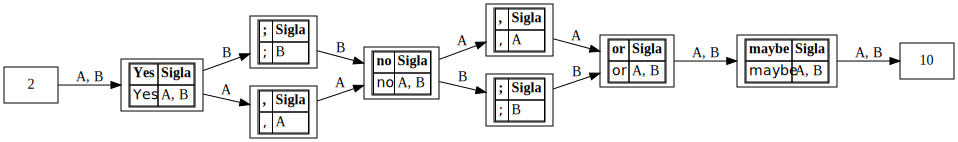

In [78]:
from collatex import *
collation = Collation()
collation.add_plain_witness('A', 'Yes, no, or maybe')
collation.add_plain_witness('B', 'Yes; no; or maybe')
svg = collate(collation, segmentation=False, output="svg")

We can work around that by changing our tokenization routine to keep punctuation together with a preceding word, but if we do that, the differences will be reported on the words, even though they have the same letters and only the trailing punctuation differs:

+---+------+-----+----+-------+
| A | Yes, | no, | or | maybe |
| B | Yes; | no; | or | maybe |
+---+------+-----+----+-------+


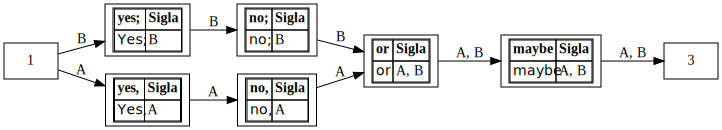

In [79]:
from collatex import *
collation = Collation()
def processToken(inputText):
    return {"t": inputText, "n": re.sub('\s+$', '', inputText.lower())}
def processWitness(inputText):
    siglum, rdg = inputText
    return {"id": siglum, "tokens": \
            [processToken(token) for token in re.findall(r'\S+\s*', rdg)]}
witnesses = [('A', 'Yes, no, or maybe'), ('B', 'Yes; no; or maybe')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}
alignment_table = collate(collation, segmentation=False)
print(alignment_table)
svg = collate(collation, segmentation=False, output="svg")

In the preceding output, the table shows that the punctuation is now combined with the preceding word, so there are only four variation points, instead of six. The SVG output shows the same, and it also shows that the readings that differ only in punctuation are treated as different, although we want them to be treated as the same. We can fix that by stripping punctuation from the "n" properties:

+---+------+-----+----+-------+
| A | Yes, | no, | or | maybe |
| B | Yes; | no; | or | maybe |
+---+------+-----+----+-------+


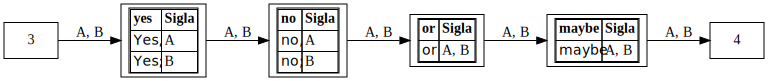

In [80]:
from collatex import *
collation = Collation()
def processToken(inputText):
    return {"t": inputText, "n": re.sub('\W+$', '', inputText.lower())}
def processWitness(inputText):
    siglum, rdg = inputText
    return {"id": siglum, "tokens": \
            [processToken(token) for token in re.findall(r'\S+\s*', rdg)]}
witnesses = [('A', 'Yes, no, or maybe'), ('B', 'Yes; no; or maybe')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}
alignment_table = collate(collation, segmentation=False)
print(alignment_table)
svg = collate(collation, segmentation=False, output="svg")

The SVG graph now shows no variation, that is, it shows that when the tokens differ only in their trailing punctuation, they are regarded as the same.

### segmentation=True

The situation is more acute when the value of `segmentation` is set to True. In this case the table combines contiguous cells that display variation, as well as those that don’t, so every new cell marks a transition from variation to non-variation or the reverse. With the default tokenization and normalization, the first variation point (“Yes”) has no variation, the second (with punctuation) varies, the third (“no”) does not vary, the fourth (punctuation) does, and the fifth (“or maybe”), doesn’t:

+---+-----+---+----+---+----------+
| A | Yes | , | no | , | or maybe |
| B | Yes | ; | no | ; | or maybe |
+---+-----+---+----+---+----------+


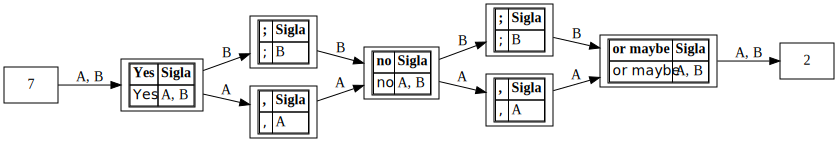

In [81]:
from collatex import *
collation = Collation()
collation.add_plain_witness('A', 'Yes, no, or maybe')
collation.add_plain_witness('B', 'Yes; no; or maybe')
alignment_table = collate(collation, segmentation=True)
print(alignment_table)
svg = collate(collation, segmentation=True, output="svg")

If, though, we combine punctuation with the preceding word token but remove it from the "n" values, we can see that these readings have no variation that we care about:

+---+-------------------+
| A | Yes, no, or maybe |
| B | Yes; no; or maybe |
+---+-------------------+


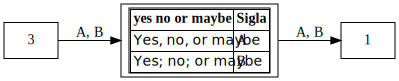

In [82]:
from collatex import *
collation = Collation()
def processToken(inputText):
    return {"t": inputText, "n": re.sub('\W+$', '', inputText.lower())}
def processWitness(inputText):
    siglum, rdg = inputText
    return {"id": siglum, "tokens": \
            [processToken(token) for token in re.findall(r'\S+\s*', rdg)]}
witnesses = [('A', 'Yes, no, or maybe'), ('B', 'Yes; no; or maybe')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}
alignment_table = collate(collation, segmentation=True)
print(alignment_table)
svg = collate(collation, segmentation=True, output="svg")